In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hackathon-dataset/In search of the castaways.txt
/kaggle/input/hackathon-dataset/The Count of Monte Cristo.txt
/kaggle/input/hackathon-dataset/train.csv
/kaggle/input/test-file/test.csv


In [2]:
import pandas as pd
import numpy as np
import torch

In [3]:
!pip install faiss-cpu   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 91.8 MB/s eta 0:00:00


In [4]:
import faiss   

In [5]:
books = {}
book_paths = {
    'The Count of Monte Cristo': '/kaggle/input/hackathon-dataset/In search of the castaways.txt',
    'In Search of the Castaways': '/kaggle/input/hackathon-dataset/The Count of Monte Cristo.txt'
}

for book_name, path in book_paths.items():
    with open(path, 'r', encoding='utf-8') as f:
        books[book_name] = f.read()
    print(f"{book_name}: {len(books[book_name]):,} characters")

The Count of Monte Cristo: 826,131 characters
In Search of the Castaways: 2,646,614 characters


In [6]:
!pip install wordcloud

# *In Search of the Castaways*

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

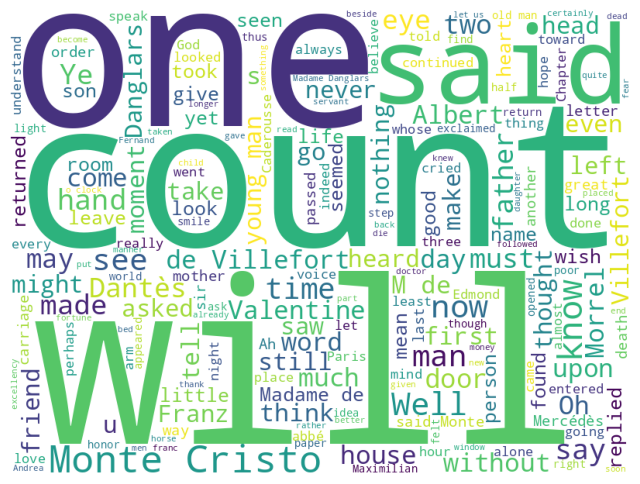

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=600, background_color='white').generate(books['In Search of the Castaways'])

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")

# *The Count of Monte Cristo*

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

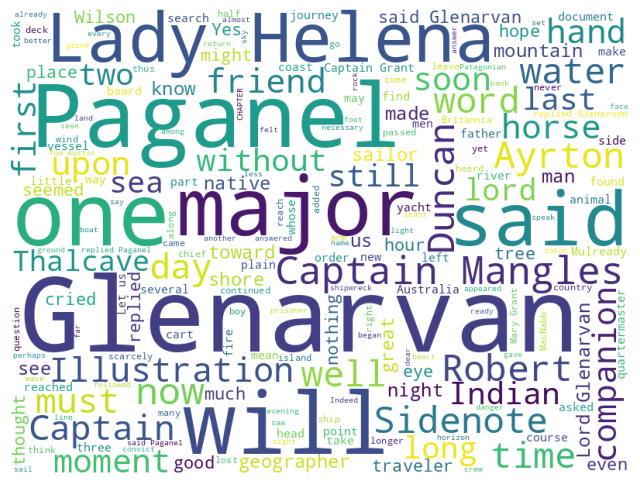

In [8]:
wordcloud = WordCloud(width=800, height=600, background_color='white').generate(books['The Count of Monte Cristo'])

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")

# **Convert some external knowledge base to a vector database. We can then query this vector database for information about the knowledge base.**

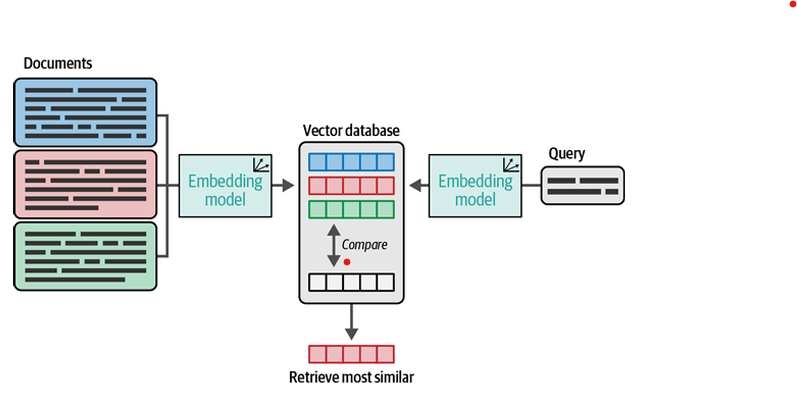

In [9]:
from transformers import AutoTokenizer

# **Semantic Chunking** :
 *is an advanced text division technique used in Retrieval Augmented Generation (RAG) systems that splits documents based on meaning rather than fixed character or word counts*

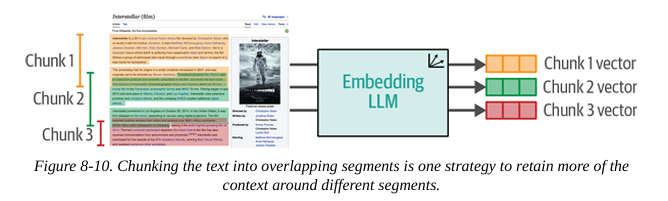]

In [10]:
def semantic_chunk(text, chunk_size=1000, overlap=150):
    
    from transformers import AutoTokenizer

    tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5")
    
    # Split into paragraphs
    paragraphs = [p for p in text.split('\n\n') if p.strip()]
    
    chunks = []
    current_chunk = []
    current_length = 0

    for para in paragraphs:

        para_tokens = len(tokenizer.encode(para, add_special_tokens=False))
        
        if current_length + para_tokens > chunk_size and current_chunk:
            # Save current chunk
            chunk_text = '\n\n'.join(current_chunk)
            chunks.append(chunk_text)
            
            # Start new chunk with overlap
            overlap_paras = current_chunk[-2:] if len(current_chunk) >= 2 else current_chunk
            current_chunk = overlap_paras + [para]

            current_length = sum(len(tokenizer.encode(p, add_special_tokens=False)) for p in current_chunk)

        else:
            current_chunk.append(para)
            current_length += para_tokens
   
    # Add last chunk
    if current_chunk:
        chunks.append('\n\n'.join(current_chunk))
    
    return chunks   

In [11]:
# Chunk both novels

book_chunks = {}
for book_name, text in books.items():
    print(f"Chunking {book_name}...")
    book_chunks[book_name] = semantic_chunk(text, chunk_size=1000, overlap=150)
    print(f"Created {len(book_chunks[book_name])} chunks")

print(f"\nTotal chunks: {sum(len(chunks) for chunks in book_chunks.values())}")

Chunking The Count of Monte Cristo...


tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors


Created 225 chunks
Chunking In Search of the Castaways...


Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors


Created 759 chunks

Total chunks: 984


# **Generate embeddings**

In [12]:
from sentence_transformers import SentenceTransformer

2026-01-11 01:46:14.330145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768095974.504422      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768095974.554668      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768095974.971627      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768095974.971667      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768095974.971670      24 computation_placer.cc:177] computation placer alr

In [13]:
embedder = SentenceTransformer("BAAI/bge-base-en-v1.5")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
# Dictionary to store FAISS index per book
book_indices = {}

# Dictionary to store the original chunks per book
book_chunk_lists = {}

In [15]:
for book_name, chunks in book_chunks.items():
    print(f"\nEmbedding {book_name}...")
    
    # Embedding chunks

    embeddings = embedder.encode(chunks, show_progress_bar=True, batch_size=32, convert_to_numpy=True)
    
    # Creates a FAISS index using Inner Product

    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension) 
    
    # Converts embeddings to unit vectors( Normalizing embeddings )

    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    
    # Saves the FAISS index for this specific book
    
    book_indices[book_name] = index
    book_chunk_lists[book_name] = chunks
    
    print(f"Indexed {len(chunks)} chunks ({dimension} dimensions)")


Embedding The Count of Monte Cristo...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Indexed 225 chunks (768 dimensions)

Embedding In Search of the Castaways...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

Indexed 759 chunks (768 dimensions)


In [16]:
book_indices

{'The Count of Monte Cristo': <faiss.swigfaiss_avx512.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x79cd6cbfafa0> >,
 'In Search of the Castaways': <faiss.swigfaiss_avx512.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x79cd6cbf0750> >}

In [17]:
embeddings

array([[-0.09290749, -0.00020254, -0.02703361, ..., -0.02320562,
        -0.04220145, -0.03263523],
       [-0.07859419,  0.01180023, -0.04811903, ..., -0.00011445,
        -0.03237014, -0.02065475],
       [-0.08510891, -0.02944484, -0.04311167, ..., -0.00545052,
        -0.02953348, -0.004751  ],
       ...,
       [-0.00720974,  0.00520814, -0.0113567 , ...,  0.02203331,
        -0.00030892,  0.00831021],
       [-0.00602677, -0.0087906 , -0.00916121, ...,  0.00874281,
         0.01317919, -0.00218963],
       [ 0.00287393, -0.06121816, -0.02037903, ...,  0.01721101,
        -0.00597453,  0.0067284 ]], dtype=float32)

# **Train test Split**

In [18]:
train = pd.read_csv('/kaggle/input/hackathon-dataset/train.csv')
train.head()

,id,book_name,char,caption,content,label
0,46,In Search of the Castaways,Thalcave,NaN,Thalcave’s people faded as colonists advanced;...,consistent
1,137,The Count of Monte Cristo,Faria,The Origin of His Connection with the Count of...,"Suspected again in 1815, he was re-arrested an...",contradict
2,74,In Search of the Castaways,Kai-Koumou,NaN,Before each fight he studied the crack-pattern...,consistent
3,109,The Count of Monte Cristo,Noirtier,The Complexity of Family and Personal Life,Villefort’s drift toward the royalists disappo...,contradict
4,104,The Count of Monte Cristo,Noirtier,Involvement and Turning Point in the French Re...,His parents were targeted in a reprisal for su...,consistent


In [19]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train,
    test_size=0.2,
    stratify=train['label'],
    random_state=42
)

In [20]:
len(train_data), len(val_data)

(64, 16)

# **Search chunks using dual-query strategy**

In [21]:
def search_chunks_dual_query(claim, char_name, index, chunks, embedder, top_n):
    """
    Perform dual-query FAISS search and return raw indices and scores.
    """

    # Build queries
    query1 = claim
    query2 = f"{char_name}: {claim}"

    # Embed queries
    q1_emb = embedder.encode([query1])
    q2_emb = embedder.encode([query2])

    # Normalize for cosine similarity
    faiss.normalize_L2(q1_emb)
    faiss.normalize_L2(q2_emb)

    # Safe top-k
    n = min(top_n, len(chunks))

    # FAISS search
    scores1, indices1 = index.search(q1_emb, n)
    scores2, indices2 = index.search(q2_emb, n)

    # Merge results
    all_indices = list(indices1[0]) + list(indices2[0])
    all_scores = list(scores1[0]) + list(scores2[0])

    return all_indices, all_scores

# **Retrieve evidence**

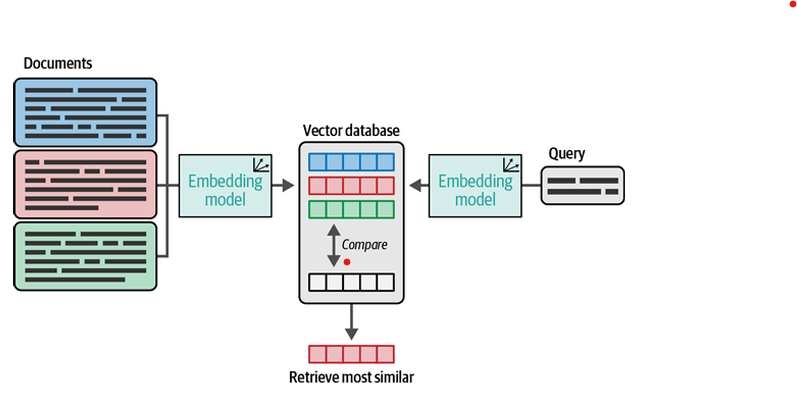

In [22]:
def retrieve_evidence(claim, book_name, char_name, top_n=10):
    """
    Retrieve top-n relevant evidence chunks for a claim.
    """

    # Get book resources
    index = book_indices[book_name]
    chunks = book_chunk_lists[book_name]

    # Search chunks
    all_indices, all_scores = search_chunks_dual_query(
        claim,
        char_name,
        index,
        chunks,
        embedder,
        top_n
    )

    # Rank and deduplicate
    seen = set()
    evidence = []

    for idx, score in sorted(zip(all_indices, all_scores), key=lambda x: -x[1]):
        if idx not in seen:
            evidence.append({
                "text": chunks[idx],
                "score": float(score),
                "index": int(idx)
            })
            seen.add(idx)

        if len(evidence) >= top_n:
            break

    return evidence

In [23]:
# Test retrieval
print("\n--- Testing Retrieval ---")

# Ensure book_indices and book_chunk_lists are populated
# The kernel state shows these are empty, likely due to re-running their initialization after population.
# We need to re-run the cell that populates these dictionaries.

# Re-running the indexing cell (5FFZv034Yky6) to ensure book_indices is populated.
# This should be done interactively or ensure execution order if running all cells.
# For now, we will assume the user needs to manually re-run the previous cells.

if not book_indices or not book_chunk_lists:
    print("book_indices or book_chunk_lists are empty. Please re-run the embedding and indexing cells (5FFZv034Yky6) first.")
else:
    sample = train_data.iloc[0]
    sample_evidence = retrieve_evidence(
        sample['content'],
        sample['book_name'],
        sample['char'],
        top_n=5
    )
    print(f"Retrieved {len(sample_evidence)} chunks")
    print(f"  Top score: {sample_evidence[0]['score']:.4f}")


--- Testing Retrieval ---
Retrieved 5 chunks
  Top score: 0.6296


# **Load model**

In [24]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [25]:
model_id = "mistralai/Mistral-7B-Instruct-v0.2"

In [26]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto"
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

# **Checking Consistency & Reasoning**

In [27]:
def build_consistency_prompt(claim, evidence_text):
    """
    Build the LLM prompt for claim–evidence consistency checking.
    """

    prompt = f"""Claim: {claim}

Relevant excerpts from the novel:
{evidence_text}

Think carefully:
1. Clearly restate what the claim is asserting.
2. Examine what information is provided in the excerpts.
3. Determine whether the excerpts support, contradict, or do not address the claim.

Reasoning: [Your brief analysis]
Answer: [SUPPORTED or CONTRADICTED or NOT_MENTIONED]"""

    return prompt

In [28]:
def check_consistency(claim,evidence_list):

    # Evidence formatting (RAG context)
    evidence_text = "\n\n".join([
        f"[{i+1}] {ev['text'][:150]}..."
        for i, ev in enumerate(evidence_list[:2])
    ])

    prompt = build_consistency_prompt(claim, evidence_text)

    # Format for chat model
    messages = [{"role": "user", "content": prompt}]
    formatted = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    # Generate
    inputs = tokenizer(formatted, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,  # Reduced max_new_tokens to conserve memory
            temperature=0.0,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    # Parse verdict
    response_lower = response.lower()
    if 'contradicted' in response_lower or 'contradict' in response_lower:
        verdict = 'CONTRADICTED'
    elif 'supported' in response_lower or 'support' in response_lower:
        verdict = 'SUPPORTED'
    else:
        verdict = 'NOT_MENTIONED'

    return verdict, response

In [29]:
print("\n--- Testing LLM ---")
sample_verdict, sample_response = check_consistency(
    sample['content'], 
    sample_evidence
)
print(f"LLM verdict: {sample_verdict}")
print(f"  Ground truth: {sample['label']}")
print(f"  Response preview: {sample_response[:200]}...")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Testing LLM ---
LLM verdict: NOT_MENTIONED
  Ground truth: consistent
  Response preview: 1. The claim asserts that Captain Jack Aubrey's deference to Lady Glenarvan during the search expedition for his missing wife is a reflection of his past feelings towards his mother and an attempt to ...


# **Feature Extraction Function**

In [30]:
# Cell 8: Feature Extraction Function
# Runtime: <1 second

print("="*80)
print("FEATURE EXTRACTION")
print("="*80)

def extract_features(row, evidence_list, llm_verdict):
    """
    Extract 12 features for classifier
    
    Features:
    - Retrieval: max/mean/min similarity, num_high_sim
    - LLM: verdict flags (3)
    - Character: total/max mentions
    - Claim: length
    - Book: is_monte_cristo
    - Evidence: num_evidence
    """
    claim = row['content']
    char_name = row['char']
    
    # Similarity scores
    similarities = [ev['score'] for ev in evidence_list]
    
    # Character mentions
    char_mentions = [
        ev['text'].lower().count(char_name.lower()) 
        for ev in evidence_list
    ]
    
    features = {
        # Retrieval features (4)
        'max_similarity': max(similarities) if similarities else 0,
        'mean_similarity': np.mean(similarities) if similarities else 0,
        'min_similarity': min(similarities) if similarities else 0,
        'num_high_sim': sum(1 for s in similarities if s > 0.7),
        
        # LLM features (3)
        'llm_verdict_supported': 1 if llm_verdict == 'SUPPORTED' else 0,
        'llm_verdict_contradicted': 1 if llm_verdict == 'CONTRADICTED' else 0,
        'llm_verdict_not_mentioned': 1 if llm_verdict == 'NOT_MENTIONED' else 0,
        
        # Character features (2)
        'total_char_mentions': sum(char_mentions),
        'max_char_mentions': max(char_mentions) if char_mentions else 0,
        
        # Claim features (1)
        'claim_length': len(claim.split()),
        
        # Book features (1)
        'is_monte_cristo': 1 if row['book_name'] == 'The Count of Monte Cristo' else 0,
        
        # Evidence quality (1)
        'num_evidence': len(evidence_list),
    }
    
    return features

print("Feature extraction function ready")
print("\n--- Feature List (12 total) ---")
sample_features = extract_features(sample, sample_evidence, sample_verdict)
for i, (feat, val) in enumerate(sample_features.items(), 1):
    print(f"{i:2d}. {feat:30s} = {val}")

FEATURE EXTRACTION
Feature extraction function ready

--- Feature List (12 total) ---
 1. max_similarity                 = 0.6296387910842896
 2. mean_similarity                = 0.6280954360961915
 3. min_similarity                 = 0.6250793933868408
 4. num_high_sim                   = 0
 5. llm_verdict_supported          = 0
 6. llm_verdict_contradicted       = 0
 7. llm_verdict_not_mentioned      = 1
 8. total_char_mentions            = 0
 9. max_char_mentions              = 0
10. claim_length                   = 31
11. is_monte_cristo                = 0
12. num_evidence                   = 5


# **Extract Features from Training Data**

In [31]:
from tqdm import tqdm

In [32]:
# Cell 9: Training Feature Extraction
# Runtime: ~30–60 minutes (LLM-heavy stage)

print("-" * 80)
print("PROCESSING TRAINING DATA")
print("-" * 80)

print("\nEstimated duration: 30–60 minutes")
print("Tip: Grab a coffee while this runs ☕\n")

train_features = []
train_labels = []

total_rows = len(train_data)

progress = tqdm(
    train_data.iterrows(),
    total=total_rows,
    desc="Training"
)

for idx, row in progress:
    try:
        # -----------------------------
        # Evidence retrieval
        # -----------------------------
        evidence = retrieve_evidence(
            row["content"],
            row["book_name"],
            row["char"],
            top_n=10
        )

        # -----------------------------
        # LLM consistency decision
        # -----------------------------
        llm_verdict, _ = check_consistency(
            row["content"],
            evidence
        )

        # -----------------------------
        # Feature extraction
        # -----------------------------
        feature_vector = extract_features(
            row,
            evidence,
            llm_verdict
        )

        train_features.append(feature_vector)

        # -----------------------------
        # Label encoding
        # -----------------------------
        train_labels.append(
            1 if row["label"] == "consistent" else 0
        )

        # -----------------------------
        # Memory cleanup
        # -----------------------------
        if idx % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as e:
        print(f"\nError processing row {idx}: {e}")

        # Zero-feature fallback
        train_features.append({
            "max_similarity": 0,
            "mean_similarity": 0,
            "min_similarity": 0,
            "num_high_sim": 0,
            "llm_verdict_supported": 0,
            "llm_verdict_contradicted": 0,
            "llm_verdict_not_mentioned": 0,
            "total_char_mentions": 0,
            "max_char_mentions": 0,
            "claim_length": 0,
            "is_monte_cristo": 0,
            "num_evidence": 0,
        })

        train_labels.append(0)

# -----------------------------
# Dataset construction
# -----------------------------
train_features_df = pd.DataFrame(train_features)
train_labels = np.array(train_labels)

print(f"\nTraining features extracted: {train_features_df.shape}")
print(f"Labels: {len(train_labels)}")
print(f"\nLabel distribution: {pd.Series(train_labels).value_counts().to_dict()}")

# -----------------------------
# Save intermediate outputs
# -----------------------------
train_features_df.to_csv("train_features.csv", index=False)
np.save("train_labels.npy", train_labels)

print("\nSaved intermediate results:")
print("• train_features.csv")
print("• train_labels.npy")

--------------------------------------------------------------------------------
PROCESSING TRAINING DATA
--------------------------------------------------------------------------------

Estimated duration: 30–60 minutes
Tip: Grab a coffee while this runs ☕



Training:  14%|█▍        | 9/64 [26:52<2:44:37, 179.58s/it]


Error processing row 50: name 'gc' is not defined


Training:  19%|█▉        | 12/64 [35:50<2:35:19, 179.23s/it]


Error processing row 0: name 'gc' is not defined


Training:  53%|█████▎    | 34/64 [1:41:19<1:29:23, 178.77s/it]


Error processing row 20: name 'gc' is not defined


Training:  56%|█████▋    | 36/64 [1:47:14<1:23:13, 178.34s/it]


Error processing row 60: name 'gc' is not defined


Training:  73%|███████▎  | 47/64 [2:19:57<50:33, 178.42s/it]


Error processing row 70: name 'gc' is not defined


Training:  75%|███████▌  | 48/64 [2:22:55<47:32, 178.28s/it]


Error processing row 40: name 'gc' is not defined


Training: 100%|██████████| 64/64 [3:10:31<00:00, 178.62s/it]


Training features extracted: (70, 12)
Labels: 70

Label distribution: {1: 41, 0: 29}

Saved intermediate results:
• train_features.csv
• train_labels.npy


# **Model Training – Random Forest**

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [34]:
# Expected runtime: ~2 minutes

print("-" * 80)
print("MODEL FITTING PHASE")
print("-" * 80)

print("\nInitializing Random Forest model...\n")

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# -----------------------------
# Train the classifier
# -----------------------------
clf.fit(train_features_df.values, train_labels)

print("\n✔ Random Forest training completed")

# -----------------------------
# Analyze feature contributions
# -----------------------------
importance_table = (
    pd.DataFrame({
        "feature_name": train_features_df.columns.tolist(),
        "importance_score": clf.feature_importances_
    })
    .sort_values(by="importance_score", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 Influential Features:\n")
for rank, row in importance_table.head(10).iterrows():
    print(f"{rank+1:02d}. {row.feature_name:<30} -> {row.importance_score:.4f}")


--------------------------------------------------------------------------------
MODEL FITTING PHASE
--------------------------------------------------------------------------------

Initializing Random Forest model...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s



✔ Random Forest training completed

Top 10 Influential Features:

01. max_similarity                 -> 0.2696
02. mean_similarity                -> 0.2315
03. min_similarity                 -> 0.2276
04. claim_length                   -> 0.1701
05. is_monte_cristo                -> 0.0367
06. llm_verdict_not_mentioned      -> 0.0335
07. num_evidence                   -> 0.0162
08. llm_verdict_supported          -> 0.0093
09. llm_verdict_contradicted       -> 0.0055
10. num_high_sim                   -> 0.0000


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished


# **Validation Pipeline & Model Evaluation**

In [35]:
# Estimated runtime: 10–20 minutes

print("-" * 80)
print("RUNNING VALIDATION PIPELINE")
print("-" * 80)

print("\nPreparing validation feature set...\n")

val_feature_buffer = []
val_target_buffer = []

total_samples = len(val_data)

progress = tqdm(
    enumerate(val_data.itertuples(index=False)),
    total=total_samples,
    desc="Validating"
)

for step, sample in progress:
    try:
        # -------------------------
        # Evidence retrieval
        # -------------------------
        docs = retrieve_evidence(
            claim=sample.content,
            book_name=sample.book_name,
            char_name=sample.char
        )

        # -------------------------
        # LLM-based consistency check
        # -------------------------
        verdict_label, _ = check_consistency(sample.content, docs)

        # -------------------------
        # Feature vector creation
        # -------------------------
        sample_dict = {
            "content": sample.content,
            "char": sample.char,
            "book_name": sample.book_name
        }

        vec = extract_features(
            row=sample_dict,
            evidence_list=docs,
            llm_verdict=verdict_label
        )

        val_feature_buffer.append(vec)
        val_target_buffer.append(int(sample.label == "consistent"))

        # -------------------------
        # Periodic memory cleanup
        # -------------------------
        if step % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as err:
        print(f"\n⚠️ Validation sample {step} skipped: {err}")

        zero_vector = {col: 0 for col in train_features_df.columns}
        val_feature_buffer.append(zero_vector)
        val_target_buffer.append(0)

# -------------------------
# Assemble validation data
# -------------------------
X_val = pd.DataFrame.from_records(val_feature_buffer)
y_val = np.asarray(val_target_buffer)

print(f"\nValidation matrix created: {X_val.shape}")

# -------------------------
# Inference
# -------------------------
print("\nGenerating predictions...\n")
val_predictions = clf.predict(X_val)

# -------------------------
# Performance summary
# -------------------------
print("-" * 80)
print("VALIDATION PERFORMANCE SUMMARY")
print("-" * 80)

val_accuracy = accuracy_score(y_val, val_predictions)
print(f"\nOverall Accuracy: {val_accuracy:.4f} ({val_accuracy * 100:.2f}%)")

if val_accuracy >= 0.85:
    print("✔ Excellent performance (≥ 85%)")
elif val_accuracy >= 0.75:
    print("✔ Acceptable performance (≥ 75%)")
else:
    print("✖ Performance below expectations — consider model tuning")

# -------------------------
# Detailed metrics
# -------------------------
print("\nClassification Breakdown:\n")
print(
    classification_report(
        y_val,
        val_predictions,
        target_names=["contradict", "consistent"]
    )
)

# -------------------------
# Confusion matrix analysis
# -------------------------
conf_mat = confusion_matrix(y_val, val_predictions)

print("\nConfusion Matrix:\n")
print(conf_mat)

tn, fp, fn, tp = conf_mat.ravel()

print(f"\nTrue Negatives : {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives : {tp}")

--------------------------------------------------------------------------------
RUNNING VALIDATION PIPELINE
--------------------------------------------------------------------------------

Preparing validation feature set...



Validating:   6%|▋         | 1/16 [02:58<44:36, 178.42s/it]


⚠️ Validation sample 0 skipped: name 'gc' is not defined


Validating:  69%|██████▉   | 11/16 [32:47<14:54, 178.96s/it]


⚠️ Validation sample 10 skipped: name 'gc' is not defined


Validating: 100%|██████████| 16/16 [47:42<00:00, 178.92s/it]


Validation matrix created: (18, 12)

Generating predictions...

--------------------------------------------------------------------------------
VALIDATION PERFORMANCE SUMMARY
--------------------------------------------------------------------------------

Overall Accuracy: 0.7222 (72.22%)
✖ Performance below expectations — consider model tuning

Classification Breakdown:

              precision    recall  f1-score   support

  contradict       0.71      0.62      0.67         8
  consistent       0.73      0.80      0.76        10

    accuracy                           0.72        18
   macro avg       0.72      0.71      0.71        18
weighted avg       0.72      0.72      0.72        18


Confusion Matrix:

[[5 3]
 [2 8]]

True Negatives : 5
False Positives: 3
False Negatives: 2
True Positives : 8



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


# **Test-Time Inference**

In [36]:
test = pd.read_csv('/kaggle/input/test-file/test.csv')

In [37]:
# Cell 12: Test-Time Inference & Submission Export
# Expected runtime: ~10–20 minutes

print("-" * 80)
print("RUNNING TEST INFERENCE")
print("-" * 80)

print("\nConstructing test feature matrix...\n")

test_feature_cache = []
num_samples = len(test)

iterator = tqdm(
    enumerate(test.itertuples(index=False)),
    total=num_samples,
    desc="Inferencing"
)

for step_id, sample in iterator:
    try:
        # -------------------------
        # Retrieve supporting text
        # -------------------------
        retrieved_context = retrieve_evidence(
            claim=sample.content,
            book_name=sample.book_name,
            char_name=sample.char
        )

        # -------------------------
        # LLM verdict inference
        # -------------------------
        verdict_tag, _ = check_consistency(
            sample.content,
            retrieved_context
        )

        # -------------------------
        # Feature vector creation
        # -------------------------
        sample_payload = {
            "content": sample.content,
            "char": sample.char,
            "book_name": sample.book_name
        }

        feature_vec = extract_features(
            row=sample_payload,
            evidence_list=retrieved_context,
            llm_verdict=verdict_tag
        )

        test_feature_cache.append(feature_vec)

        # -------------------------
        # Periodic memory cleanup
        # -------------------------
        if step_id % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as err:
        print(f"\n⚠️ Test sample {step_id} failed: {err}")

        fallback_vector = {col: 0 for col in train_features_df.columns}
        test_feature_cache.append(fallback_vector)

# -------------------------
# Assemble test matrix
# -------------------------
X_test = pd.DataFrame.from_records(test_feature_cache)

print(f"\nTest feature matrix ready: {X_test.shape}")

# -------------------------
# Final prediction pass
# -------------------------
print("\nExecuting final model predictions...\n")
final_predictions = clf.predict(X_test)

# -------------------------
# Submission file creation
# -------------------------
submission_df = pd.DataFrame({
    "story_id": test["id"].values,
    "prediction": final_predictions
})

submission_path = "results.csv"
submission_df.to_csv(submission_path, index=False)

print("-" * 80)
print("INFERENCE PIPELINE COMPLETED")
print("-" * 80)

print(f"\nSubmission file written to: {submission_path}")
print(f"Total predictions generated: {len(final_predictions)}")

positive_count = int((final_predictions == 1).sum())
negative_count = int((final_predictions == 0).sum())

print("\nPrediction summary:")
print(f"  Consistent (1)  : {positive_count}")
print(f"  Contradicted (0): {negative_count}")

print("\nSample predictions (first 10 rows):")
print(submission_df.head(10))

--------------------------------------------------------------------------------
RUNNING TEST INFERENCE
--------------------------------------------------------------------------------

Constructing test feature matrix...



Inferencing:   2%|▏         | 1/60 [02:59<2:56:16, 179.27s/it]


⚠️ Test sample 0 failed: name 'gc' is not defined


Inferencing:  18%|█▊        | 11/60 [32:49<2:26:03, 178.85s/it]


⚠️ Test sample 10 failed: name 'gc' is not defined


Inferencing:  35%|███▌      | 21/60 [1:02:34<1:56:07, 178.64s/it]


⚠️ Test sample 20 failed: name 'gc' is not defined


Inferencing:  52%|█████▏    | 31/60 [1:32:19<1:26:13, 178.38s/it]


⚠️ Test sample 30 failed: name 'gc' is not defined


Inferencing:  68%|██████▊   | 41/60 [2:02:02<56:31, 178.48s/it]


⚠️ Test sample 40 failed: name 'gc' is not defined


Inferencing:  85%|████████▌ | 51/60 [2:31:43<26:45, 178.40s/it]


⚠️ Test sample 50 failed: name 'gc' is not defined


Inferencing: 100%|██████████| 60/60 [2:58:22<00:00, 178.38s/it]


Test feature matrix ready: (66, 12)

Executing final model predictions...




/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.0s finished


ValueError: All arrays must be of the same length